# Gradient Boosting: Advanced Ensemble Methods

## Overview

**Gradient Boosting** is a powerful ensemble technique that builds trees **sequentially**, where each tree corrects errors of previous trees. Unlike Random Forest (parallel bagging), Gradient Boosting uses **boosting** - adding weak learners iteratively to minimize a loss function.

## Key Concepts

### Boosting Algorithm

**Sequential Learning**:
\[
F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)
\]

where:
- \(F_m(x)\): Ensemble after \(m\) trees
- \(\eta\): Learning rate (shrinkage)
- \(h_m(x)\): New tree fitted to residuals

### Gradient Descent in Function Space

**Loss Function**:
\[
L(y, F(x)) = \sum_{i=1}^{n} l(y_i, F(x_i))
\]

**Negative Gradient** (pseudo-residuals):
\[
r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}
\]

**Tree Update**:
\[
F_m(x) = F_{m-1}(x) + \eta \sum_{j=1}^{J_m} \gamma_{jm} I(x \in R_{jm})
\]

### Key Hyperparameters

- **n_estimators**: Number of boosting stages
- **learning_rate** (\(\eta\)): Shrinkage parameter
- **max_depth**: Depth of individual trees (usually 3-8)
- **subsample**: Fraction of samples for each tree (stochastic GB)
- **min_samples_split/leaf**: Regularization

## Topics Covered

1. GradientBoostingClassifier / Regressor
2. HistGradientBoostingClassifier / Regressor (faster)
3. Learning rate and n_estimators trade-off
4. Early stopping
5. Feature importance
6. Comparison with Random Forest
7. Real-world applications
8. Introduction to XGBoost

## Setup and Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    GradientBoostingClassifier, GradientBoostingRegressor,
    HistGradientBoostingClassifier, HistGradientBoostingRegressor,
    RandomForestClassifier, RandomForestRegressor
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, learning_curve
)
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, r2_score, roc_auc_score, roc_curve, log_loss
)
from sklearn.datasets import (
    make_classification, make_regression,
    load_breast_cancer, load_diabetes
)
import time

np.random.seed(42)
sns.set_style('whitegrid')
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Gradient Boosting Basics

### 1.1 Classification Example

In [2]:
# Generate dataset
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    random_state=42
)

print("Classification Dataset")
print("="*70)
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Classification Dataset
Samples: 1000
Features: 20
Classes: [0 1]

Train: 800, Test: 200


In [3]:
# Train Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

print("Training Gradient Boosting Classifier...")
start_time = time.time()
gb_clf.fit(X_train, y_train)
train_time = time.time() - start_time

print(f"\nTraining completed in {train_time:.2f} seconds")

# Evaluate
train_acc = gb_clf.score(X_train, y_train)
test_acc = gb_clf.score(X_test, y_test)

print(f"\nPerformance:")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy:  {test_acc:.4f}")
print(f"  Overfitting Gap: {train_acc - test_acc:.4f}")

# Predictions
y_pred = gb_clf.predict(X_test)
y_proba = gb_clf.predict_proba(X_test)[:, 1]

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Gradient Boosting Classifier...

Training completed in 1.80 seconds

Performance:
  Train Accuracy: 0.9950
  Test Accuracy:  0.9050
  Overfitting Gap: 0.0900

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       100
           1       0.89      0.92      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



### 1.2 Comparison: Random Forest vs Gradient Boosting

In [4]:
# Train Random Forest for comparison
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Compare
models = {
    'Random Forest': rf_clf,
    'Gradient Boosting': gb_clf
}

print("Random Forest vs Gradient Boosting")
print("="*70)

results = []
for name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Train_Acc': train_acc,
        'Test_Acc': test_acc,
        'AUC': auc
    })
    
    print(f"\n{name}:")
    print(f"  Train: {train_acc:.4f}, Test: {test_acc:.4f}")
    print(f"  AUC: {auc:.4f}")

results_df = pd.DataFrame(results)
print("\n" + "="*70)
print(results_df.to_string(index=False))

print("\n💡 Key Differences:")
print("  RF: Parallel training, less prone to overfitting")
print("  GB: Sequential training, often higher accuracy with tuning")

Random Forest vs Gradient Boosting

Random Forest:
  Train: 1.0000, Test: 0.9250
  AUC: 0.9752

Gradient Boosting:
  Train: 0.9950, Test: 0.9050
  AUC: 0.9727

            Model  Train_Acc  Test_Acc    AUC
    Random Forest      1.000     0.925 0.9752
Gradient Boosting      0.995     0.905 0.9727

💡 Key Differences:
  RF: Parallel training, less prone to overfitting
  GB: Sequential training, often higher accuracy with tuning


## 2. Learning Rate and N_Estimators Trade-off

### 2.1 Effect of Learning Rate

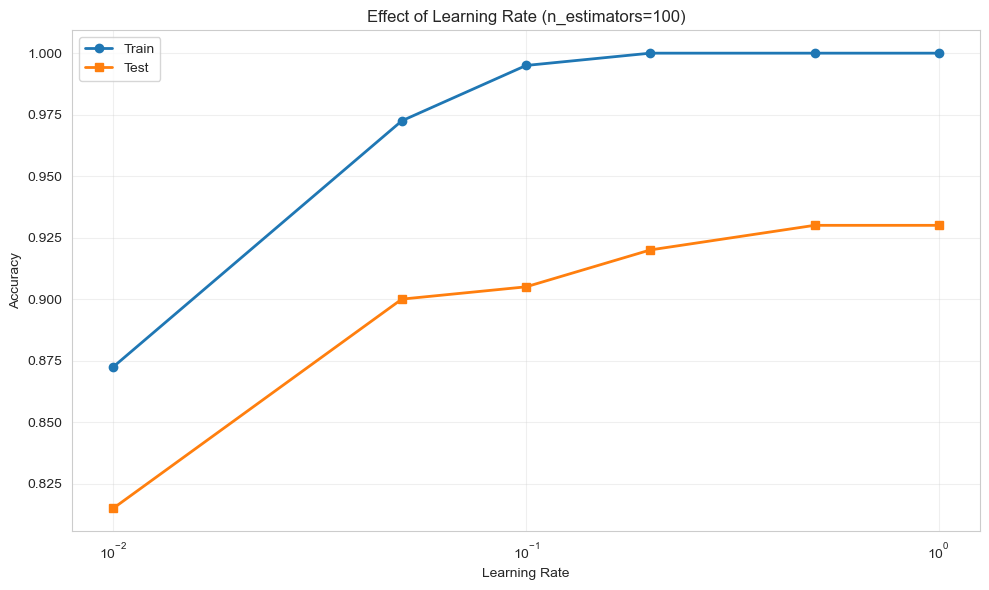

Learning Rate Analysis
LR=0.01: Train=0.8725, Test=0.8150, Gap=0.0575
LR=0.05: Train=0.9725, Test=0.9000, Gap=0.0725
LR=0.10: Train=0.9950, Test=0.9050, Gap=0.0900
LR=0.20: Train=1.0000, Test=0.9200, Gap=0.0800
LR=0.50: Train=1.0000, Test=0.9300, Gap=0.0700
LR=1.00: Train=1.0000, Test=0.9300, Gap=0.0700

💡 Observations:
  - Low LR: Underfitting (needs more trees)
  - High LR: Overfitting risk
  - Sweet spot: 0.05-0.1 typically
  - Lower LR needs more estimators (better generalization)


In [5]:
# Test different learning rates
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
n_estimators = 100

train_scores = []
test_scores = []

for lr in learning_rates:
    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=lr,
        max_depth=3,
        random_state=42
    )
    gb.fit(X_train, y_train)
    
    train_scores.append(gb.score(X_train, y_train))
    test_scores.append(gb.score(X_test, y_test))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_scores, 'o-', label='Train', linewidth=2)
plt.plot(learning_rates, test_scores, 's-', label='Test', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title(f'Effect of Learning Rate (n_estimators={n_estimators})')
plt.legend()
plt.grid(alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.show()

print("Learning Rate Analysis")
print("="*70)
for lr, train_acc, test_acc in zip(learning_rates, train_scores, test_scores):
    print(f"LR={lr:4.2f}: Train={train_acc:.4f}, Test={test_acc:.4f}, Gap={train_acc-test_acc:.4f}")

print("\n💡 Observations:")
print("  - Low LR: Underfitting (needs more trees)")
print("  - High LR: Overfitting risk")
print("  - Sweet spot: 0.05-0.1 typically")
print("  - Lower LR needs more estimators (better generalization)")

### 2.2 Staged Predictions (Learning Curve)

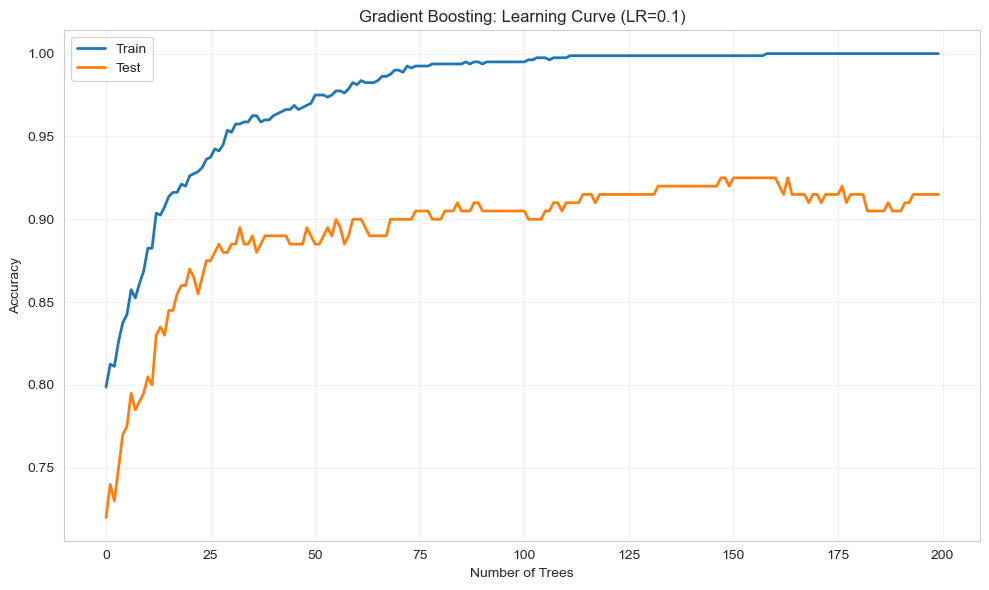


Optimal number of trees: 148
Best test accuracy: 0.9250

💡 After 148 trees, model starts overfitting


In [6]:
# Train model and track performance at each stage
gb_staged = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_staged.fit(X_train, y_train)

# Get staged predictions
train_scores_staged = []
test_scores_staged = []

for y_pred_train in gb_staged.staged_predict(X_train):
    train_scores_staged.append(accuracy_score(y_train, y_pred_train))

for y_pred_test in gb_staged.staged_predict(X_test):
    test_scores_staged.append(accuracy_score(y_test, y_pred_test))

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_scores_staged, label='Train', linewidth=2)
plt.plot(test_scores_staged, label='Test', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting: Learning Curve (LR=0.1)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find optimal number of trees
optimal_n = np.argmax(test_scores_staged) + 1
print(f"\nOptimal number of trees: {optimal_n}")
print(f"Best test accuracy: {max(test_scores_staged):.4f}")
print(f"\n💡 After {optimal_n} trees, model starts overfitting")

## 3. HistGradientBoosting (Faster Implementation)

### 3.1 Speed and Performance Comparison

In [7]:
# Create larger dataset
X_large, y_large = make_classification(
    n_samples=10000,
    n_features=50,
    n_informative=40,
    random_state=42
)

X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(
    X_large, y_large, test_size=0.2, random_state=42
)

print("Large Dataset Comparison")
print("="*70)
print(f"Train samples: {X_train_large.shape[0]}")
print(f"Features: {X_train_large.shape[1]}")

# Traditional GradientBoosting
print("\nTraining GradientBoostingClassifier...")
start = time.time()
gb_traditional = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_traditional.fit(X_train_large, y_train_large)
time_traditional = time.time() - start
acc_traditional = gb_traditional.score(X_test_large, y_test_large)

# HistGradientBoosting
print("Training HistGradientBoostingClassifier...")
start = time.time()
hist_gb = HistGradientBoostingClassifier(
    max_iter=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
hist_gb.fit(X_train_large, y_train_large)
time_hist = time.time() - start
acc_hist = hist_gb.score(X_test_large, y_test_large)

# Results
print("\n" + "="*70)
print("Results:")
print("="*70)
print(f"\nGradientBoostingClassifier:")
print(f"  Time: {time_traditional:.2f}s")
print(f"  Accuracy: {acc_traditional:.4f}")

print(f"\nHistGradientBoostingClassifier:")
print(f"  Time: {time_hist:.2f}s")
print(f"  Accuracy: {acc_hist:.4f}")

speedup = time_traditional / time_hist
print(f"\n💡 Speedup: {speedup:.1f}x faster!")
print(f"   Accuracy difference: {abs(acc_traditional - acc_hist):.4f}")

print("\nKey Differences:")
print("  - HistGB uses histogram-based splitting (bins features)")
print("  - Much faster on large datasets (>10K samples)")
print("  - Similar or better accuracy")
print("  - Native missing value support")
print("  - Parameter: max_iter instead of n_estimators")

Large Dataset Comparison
Train samples: 8000
Features: 50

Training GradientBoostingClassifier...
Training HistGradientBoostingClassifier...

Results:

GradientBoostingClassifier:
  Time: 15.97s
  Accuracy: 0.9025

HistGradientBoostingClassifier:
  Time: 4.07s
  Accuracy: 0.9075

💡 Speedup: 3.9x faster!
   Accuracy difference: 0.0050

Key Differences:
  - HistGB uses histogram-based splitting (bins features)
  - Much faster on large datasets (>10K samples)
  - Similar or better accuracy
  - Native missing value support
  - Parameter: max_iter instead of n_estimators


### 3.2 Early Stopping with HistGradientBoosting

HistGradientBoosting with Early Stopping

Stopped at iteration: 200
Test accuracy: 0.9515


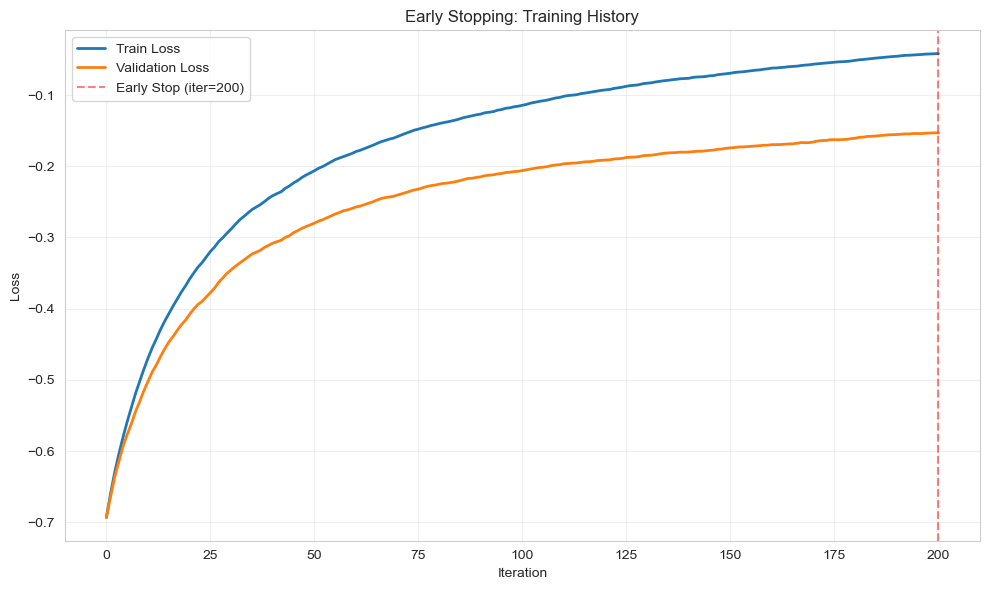


💡 Early Stopping Benefits:
  - Prevents overfitting automatically
  - Saves computation time
  - No need to tune n_estimators precisely


In [8]:
# HistGB with early stopping
hist_gb_es = HistGradientBoostingClassifier(
    max_iter=200,
    learning_rate=0.1,
    max_depth=5,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    random_state=42
)

print("HistGradientBoosting with Early Stopping")
print("="*70)
hist_gb_es.fit(X_train_large, y_train_large)

print(f"\nStopped at iteration: {hist_gb_es.n_iter_}")
print(f"Test accuracy: {hist_gb_es.score(X_test_large, y_test_large):.4f}")

# Plot training history
train_scores_hist = hist_gb_es.train_score_
val_scores_hist = hist_gb_es.validation_score_

plt.figure(figsize=(10, 6))
plt.plot(train_scores_hist, label='Train Loss', linewidth=2)
plt.plot(val_scores_hist, label='Validation Loss', linewidth=2)
plt.axvline(x=hist_gb_es.n_iter_, color='r', linestyle='--', 
           alpha=0.5, label=f'Early Stop (iter={hist_gb_es.n_iter_})')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Early Stopping: Training History')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Early Stopping Benefits:")
print("  - Prevents overfitting automatically")
print("  - Saves computation time")
print("  - No need to tune n_estimators precisely")

## 4. Gradient Boosting Regression

### 4.1 Diabetes Dataset

In [9]:
# Load diabetes
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

print("Gradient Boosting Regression: Diabetes Dataset")
print("="*70)
print(f"Samples: {X_diabetes.shape[0]}")
print(f"Features: {X_diabetes.shape[1]}")

# Split
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(
    X_diabetes, y_diabetes, test_size=0.2, random_state=42
)

# Train models
models_reg = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=100, learning_rate=0.1, max_depth=3, random_state=42
    )
}

print("\nModel Comparison:")
print("="*70)

results_reg = []
for name, model in models_reg.items():
    model.fit(X_train_db, y_train_db)
    
    y_train_pred = model.predict(X_train_db)
    y_test_pred = model.predict(X_test_db)
    
    train_r2 = r2_score(y_train_db, y_train_pred)
    test_r2 = r2_score(y_test_db, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_db, y_test_pred))
    
    results_reg.append({
        'Model': name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse
    })
    
    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.2f}")

results_reg_df = pd.DataFrame(results_reg)
print("\n" + "="*70)
print(results_reg_df.to_string(index=False))

Gradient Boosting Regression: Diabetes Dataset
Samples: 442
Features: 10

Model Comparison:

Random Forest:
  Train R²: 0.9242, Test R²: 0.4428
  Test RMSE: 54.33

GradientBoosting:
  Train R²: 0.8359, Test R²: 0.4529
  Test RMSE: 53.84

HistGradientBoosting:
  Train R²: 0.7904, Test R²: 0.4666
  Test RMSE: 53.16

               Model  Train_R2  Test_R2  Test_RMSE
       Random Forest  0.924216 0.442823  54.332408
    GradientBoosting  0.835903 0.452934  53.837131
HistGradientBoosting  0.790372 0.466626  53.159149


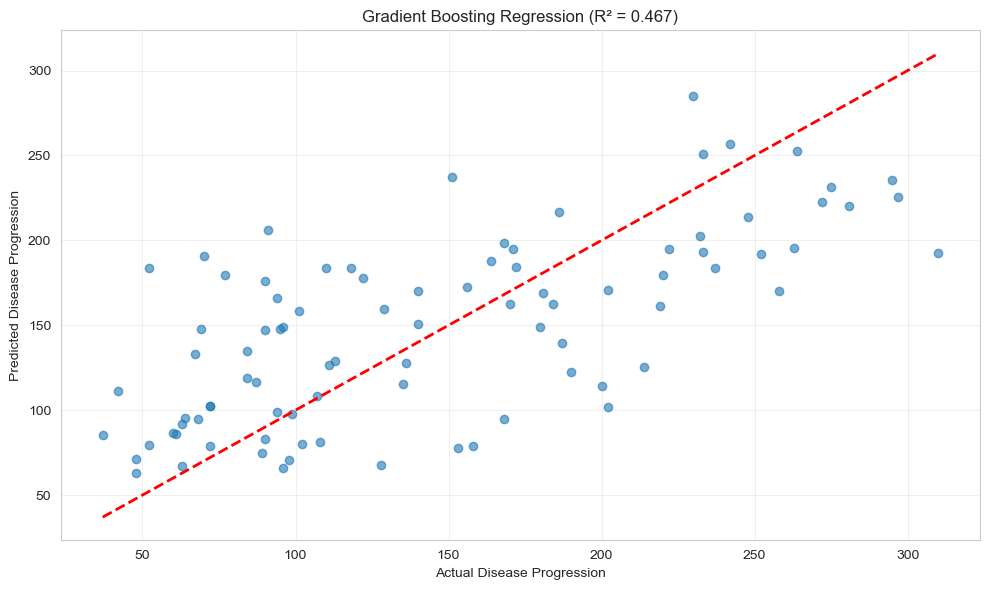


Feature Importance: Diabetes Progression
Feature  Importance
    bmi    0.393101
     s5    0.249583
     bp    0.082979
     s2    0.061490
    age    0.049612
     s6    0.046681
     s1    0.038892
     s3    0.036588
     s4    0.028596
    sex    0.012478


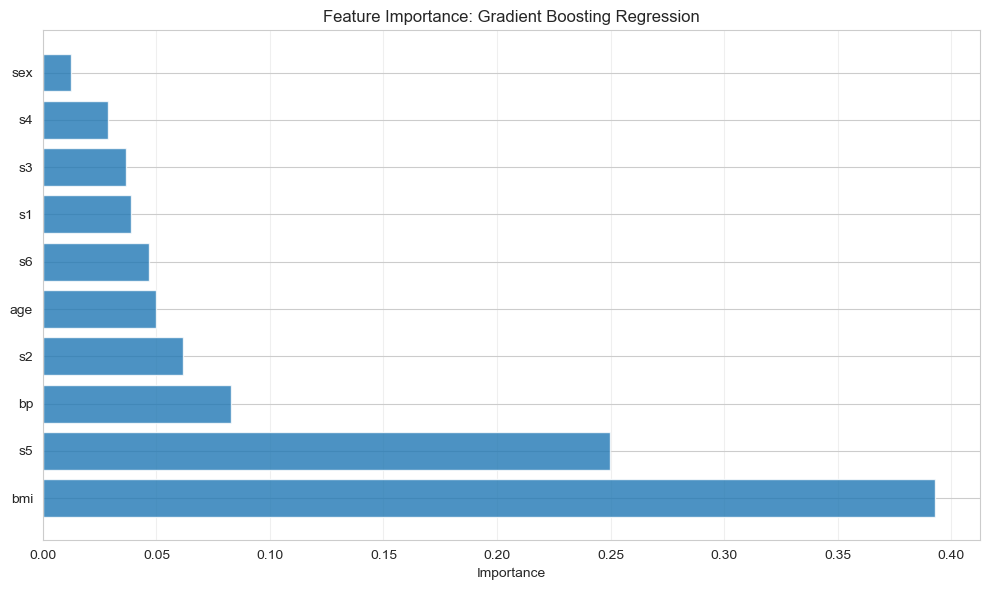

In [10]:
# Visualize best model (GradientBoosting)
gb_reg = models_reg['GradientBoosting']
y_pred_db = gb_reg.predict(X_test_db)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_db, y_pred_db, alpha=0.6)
plt.plot([y_test_db.min(), y_test_db.max()], 
         [y_test_db.min(), y_test_db.max()], 'r--', lw=2)
plt.xlabel('Actual Disease Progression')
plt.ylabel('Predicted Disease Progression')
plt.title(f'Gradient Boosting Regression (R² = {test_r2:.3f})')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance
importances = gb_reg.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': diabetes.feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importance: Diabetes Progression")
print("="*70)
print(feature_importance_df.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], 
        feature_importance_df['Importance'], alpha=0.8)
plt.xlabel('Importance')
plt.title('Feature Importance: Gradient Boosting Regression')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 5. Real-World Application: Breast Cancer Detection

### 5.1 Hyperparameter Tuning

In [11]:
# Load breast cancer
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print("Breast Cancer Detection with Gradient Boosting")
print("="*70)
print(f"Samples: {X_cancer.shape[0]}")
print(f"Features: {X_cancer.shape[1]}")

# Split
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# Grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nPerforming Grid Search...")
grid_search.fit(X_train_cancer, y_train_cancer)

print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV AUC: {grid_search.best_score_:.4f}")

# Evaluate
best_gb = grid_search.best_estimator_
y_pred_cancer = best_gb.predict(X_test_cancer)
y_proba_cancer = best_gb.predict_proba(X_test_cancer)[:, 1]

test_acc = accuracy_score(y_test_cancer, y_pred_cancer)
test_auc = roc_auc_score(y_test_cancer, y_proba_cancer)

print(f"\nTest Performance:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  AUC: {test_auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_cancer, y_pred_cancer,
                          target_names=cancer.target_names))

Breast Cancer Detection with Gradient Boosting
Samples: 569
Features: 30

Performing Grid Search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters:
  learning_rate: 0.1
  max_depth: 3
  min_samples_split: 2
  n_estimators: 200

Best CV AUC: 0.9899

Test Performance:
  Accuracy: 0.9561
  AUC: 0.9897

Classification Report:
              precision    recall  f1-score   support

   malignant       0.97      0.90      0.94        42
      benign       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



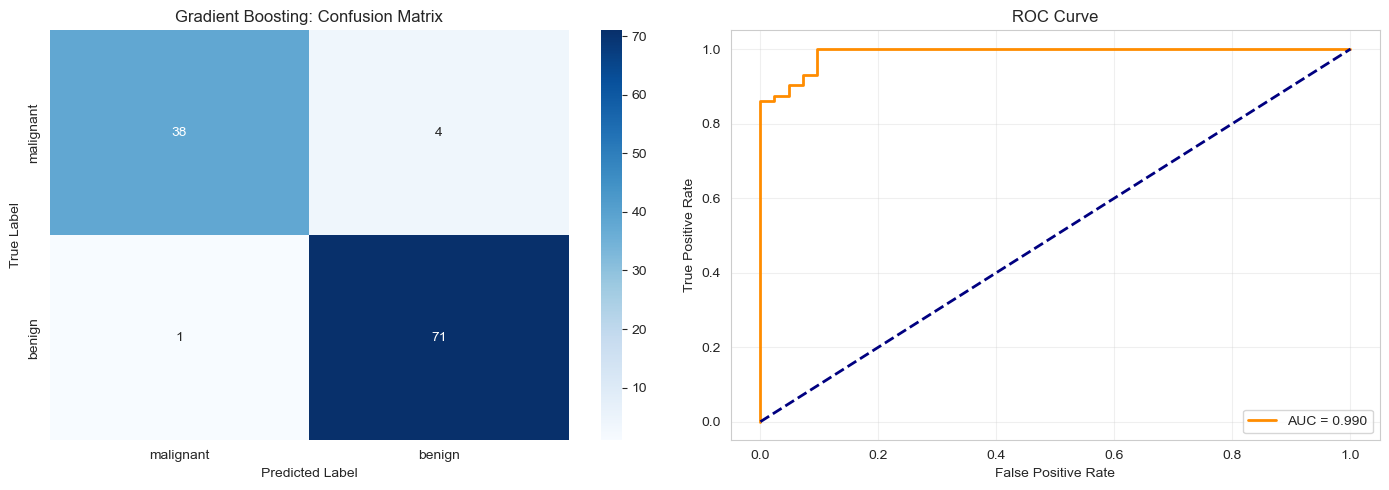


Top 15 Features:
                Feature  Importance
           worst radius    0.435471
        worst perimeter    0.271465
   worst concave points    0.106543
          worst texture    0.052636
    mean concave points    0.031206
          texture error    0.026922
             worst area    0.022316
        worst concavity    0.010820
       worst smoothness    0.010712
             area error    0.005350
      worst compactness    0.004288
           mean texture    0.003581
        perimeter error    0.003221
           radius error    0.002132
worst fractal dimension    0.001718


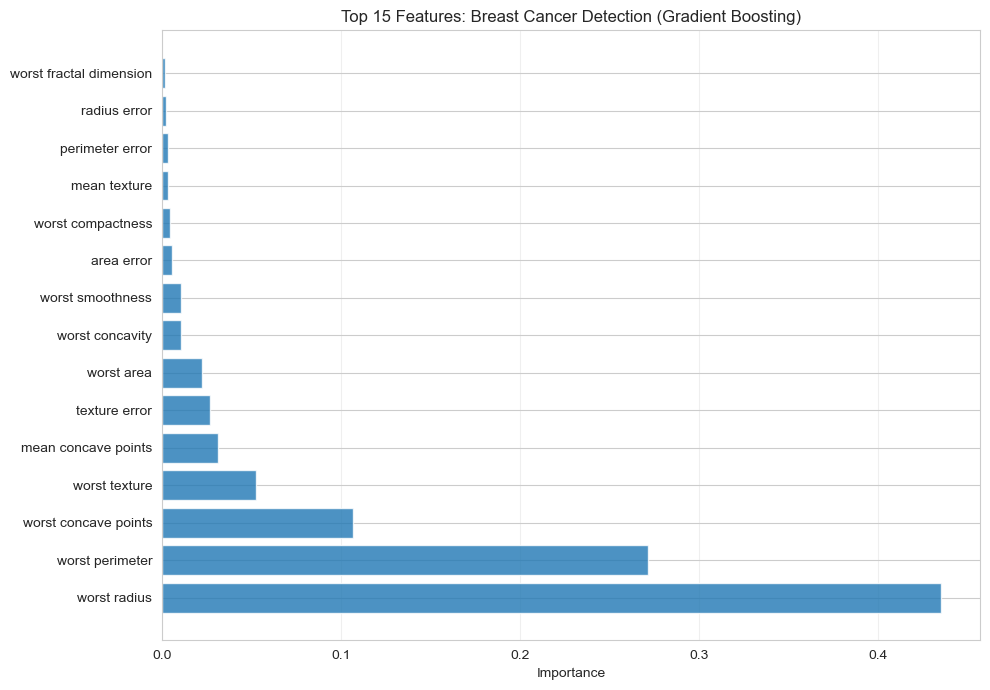

In [12]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test_cancer, y_pred_cancer)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cancer.target_names,
            yticklabels=cancer.target_names,
            ax=axes[0])
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_title('Gradient Boosting: Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_cancer, y_proba_cancer)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {test_auc:.3f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance
importances_cancer = best_gb.feature_importances_
feature_importance_cancer = pd.DataFrame({
    'Feature': cancer.feature_names,
    'Importance': importances_cancer
}).sort_values('Importance', ascending=False).head(15)

print("\nTop 15 Features:")
print(feature_importance_cancer.to_string(index=False))

plt.figure(figsize=(10, 7))
plt.barh(feature_importance_cancer['Feature'], 
        feature_importance_cancer['Importance'], alpha=0.8)
plt.xlabel('Importance')
plt.title('Top 15 Features: Breast Cancer Detection (Gradient Boosting)')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 6. Introduction to XGBoost (Optional)

### 6.1 XGBoost vs Sklearn GradientBoosting

In [13]:
# Check if XGBoost is available
try:
    import xgboost as xgb
    xgboost_available = True
    print("XGBoost is installed!")
except ImportError:
    xgboost_available = False
    print("XGBoost not installed. Install with: pip install xgboost")

if xgboost_available:
    print("\nXGBoost vs Sklearn GradientBoosting")
    print("="*70)
    
    # Train XGBoost
    xgb_clf = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='logloss'
    )
    
    start = time.time()
    xgb_clf.fit(X_train_cancer, y_train_cancer)
    time_xgb = time.time() - start
    
    # Train Sklearn GB
    gb_sklearn = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    
    start = time.time()
    gb_sklearn.fit(X_train_cancer, y_train_cancer)
    time_sklearn = time.time() - start
    
    # Compare
    acc_xgb = xgb_clf.score(X_test_cancer, y_test_cancer)
    acc_sklearn = gb_sklearn.score(X_test_cancer, y_test_cancer)
    
    print(f"\nXGBoost:")
    print(f"  Time: {time_xgb:.2f}s")
    print(f"  Accuracy: {acc_xgb:.4f}")
    
    print(f"\nSklearn GradientBoosting:")
    print(f"  Time: {time_sklearn:.2f}s")
    print(f"  Accuracy: {acc_sklearn:.4f}")
    
    print("\n💡 XGBoost Advantages:")
    print("  - Often faster (especially on large datasets)")
    print("  - Regularization (L1, L2)")
    print("  - Handling missing values")
    print("  - Built-in cross-validation")
    print("  - Feature importance types")
    print("  - GPU support")
else:
    print("\nXGBoost Key Features:")
    print("  - Extreme Gradient Boosting")
    print("  - Regularization (L1, L2) to prevent overfitting")
    print("  - Parallel processing")
    print("  - Tree pruning using max_depth")
    print("  - Built-in cross-validation")
    print("  - Native handling of missing values")
    print("  - Multiple objective functions")
    print("\n  Install: pip install xgboost")

XGBoost is installed!

XGBoost vs Sklearn GradientBoosting

XGBoost:
  Time: 2.22s
  Accuracy: 0.9474

Sklearn GradientBoosting:
  Time: 0.47s
  Accuracy: 0.9561

💡 XGBoost Advantages:
  - Often faster (especially on large datasets)
  - Regularization (L1, L2)
  - Handling missing values
  - Built-in cross-validation
  - Feature importance types
  - GPU support


## Summary and Best Practices

### Quick Reference

```python
from sklearn.ensemble import (
    GradientBoostingClassifier, GradientBoostingRegressor,
    HistGradientBoostingClassifier, HistGradientBoostingRegressor
)

# Standard Gradient Boosting
gb_clf = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Shrinkage (0.01-0.3)
    max_depth=3,            # Tree depth (3-8 typical)
    subsample=1.0,          # Fraction of samples (0.5-1.0)
    min_samples_split=2,    # Min samples to split
    min_samples_leaf=1,     # Min samples per leaf
    random_state=42
)

# Histogram-based (faster for large datasets)
hist_gb = HistGradientBoostingClassifier(
    max_iter=100,           # Number of iterations
    learning_rate=0.1,
    max_depth=5,
    early_stopping=True,    # Enable early stopping
    n_iter_no_change=10,    # Patience for early stopping
    validation_fraction=0.1,
    random_state=42
)
```

### Advantages

✓ **High accuracy**: Often best performance on tabular data
✓ **Handles non-linearity**: Captures complex patterns
✓ **Feature interactions**: Automatically captures interactions
✓ **Robust to outliers**: (with appropriate loss functions)
✓ **No scaling needed**: Tree-based
✓ **Feature importance**: Built-in

### Disadvantages

❌ **Sequential training**: Slower than Random Forest
❌ **Overfitting risk**: Needs careful tuning
❌ **Many hyperparameters**: Requires tuning
❌ **Less interpretable**: Ensemble of trees
❌ **Sensitive to noisy data**: Can overfit noise

### Best Practices

1. ✓ **Start with low learning rate** (0.01-0.1) + many trees (100-1000)
2. ✓ **Shallow trees** (max_depth=3-8) work best
3. ✓ **Use early stopping** to find optimal n_estimators
4. ✓ **Monitor train vs validation** to prevent overfitting
5. ✓ **Use HistGB for large datasets** (>10K samples)
6. ✓ **Tune learning_rate and n_estimators together**
7. ✓ **Try subsample < 1.0** (stochastic GB) for regularization
8. ✓ **Cross-validate** for reliable performance estimates

### Key Hyperparameters

| Parameter | Typical Range | Effect |
|-----------|---------------|--------|
| `learning_rate` | 0.01-0.3 | Lower = better generalization (need more trees) |
| `n_estimators` | 100-1000 | More trees (with low LR) = better |
| `max_depth` | 3-8 | Deeper = more complex (risk overfitting) |
| `subsample` | 0.5-1.0 | < 1.0 adds randomness (regularization) |
| `min_samples_split` | 2-20 | Higher = simpler trees |
| `min_samples_leaf` | 1-10 | Higher = smoother predictions |

### Hyperparameter Tuning Strategy

**Step 1**: Fix learning_rate=0.1, tune tree structure
- max_depth, min_samples_split, min_samples_leaf

**Step 2**: Tune n_estimators with early stopping
- Find optimal number of trees

**Step 3**: Lower learning_rate, increase n_estimators
- E.g., LR=0.05 with 2x trees, or LR=0.01 with 10x trees

**Step 4**: Tune subsample for stochastic GB
- Try 0.8 or 0.5 for additional regularization

### When to Use Gradient Boosting

✓ **Good for:**
- Structured/tabular data
- Kaggle competitions (often wins)
- Need highest accuracy
- Medium-sized datasets
- Can invest time in tuning

✗ **Consider alternatives:**
- Need fast prototyping → Random Forest
- Very large datasets → LightGBM, CatBoost
- Need interpretability → Linear models, single tree
- Real-time predictions → Simpler models
- High-dimensional sparse data → Linear models

### GradientBoosting vs HistGradientBoosting

| Aspect | GradientBoosting | HistGradientBoosting |
|--------|------------------|----------------------|
| Speed | Slower | 5-10x faster |
| Dataset size | < 10K samples | > 10K samples |
| Missing values | Manual handling | Native support |
| Memory | Higher | Lower |
| Accuracy | Similar | Similar |
| Scikit-learn | Traditional | Modern (v0.21+) |

### Popular Gradient Boosting Libraries

1. **Scikit-learn**: GradientBoosting, HistGradientBoosting
2. **XGBoost**: Extreme Gradient Boosting (most popular)
3. **LightGBM**: Microsoft's fast implementation
4. **CatBoost**: Yandex's categorical-friendly version

### Next Steps

- SHAP values for model interpretation
- XGBoost, LightGBM, CatBoost
- Handling categorical features
- Stacking and blending
- Hyperparameter optimization (Optuna, Hyperopt)